In [1]:
from snn_delays.snn_refactored import SNN
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.train_utils_refact_minimal import train, get_device, propagate_batch_simple, to_plot
from snn_delays.utils.test_behavior import tb_addtask_refact
# from snn_delays.utils.visualization_utils import plot_taus
import numpy as np
device = get_device()

c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on: cuda:0


In [2]:
time_window = 20
batch_size = 32 # 128: anil kag

ckpt_dir = 'multiaddtask_04_2025_tests'

dataset = 'copymemory_episodic'

num_epochs = 3000 # important: epochs here refer to iteration steps

dataset_size = batch_size*num_epochs

DL = DatasetLoader(dataset=dataset, caching='gpu', 
                   dataset_size = dataset_size,
                   num_workers=0, batch_size=batch_size, 
                   total_time=time_window)

train_loader, test_loader, dataset_dict = DL.get_dataloaders()
dataset_dict["time_ms"] = 2e3

for img, lbl in train_loader:
    print(img.shape)
    print(lbl.shape)
    break

Initializing GPU cache for 96000 samples...
Cache initialized in 10.96 seconds
Initializing GPU cache for 32 samples...
Cache initialized in 0.00 seconds
torch.Size([32, 20, 3])
torch.Size([32, 2, 2])


In [3]:
num_h = 64

tau_m = 'log-uniform-st'

extra_kwargs = {'multifeedforward':3}
snn_f = SNN(dataset_dict, structure=(num_h, 2, 'mf'), win=time_window, tau_m=tau_m,
             loss_fn='mem_prediction', batch_size=batch_size, device=device, debug=False, **extra_kwargs)

snn_f.set_layers()
snn_f.to(device)

snn_rnn = SNN(dataset_dict, structure=(num_h, 2, 'r'), win=time_window, tau_m=tau_m,
               loss_fn='mem_prediction', batch_size=batch_size, device=device, debug=False)

snn_rnn.set_layers()
snn_rnn.to(device)

extra_kwargs = {'delay_range':(18, 1),
                'pruned_delays': 3}

snn_rd = SNN(dataset_dict, structure=(num_h, 2, 'd'), win=time_window, tau_m=tau_m,
               loss_fn='mem_prediction', batch_size=batch_size, device=device, debug=False, **extra_kwargs)

snn_rd.set_layers()
snn_rd.to(device)

Delta t: 100.0 ms
Delta t: 100.0 ms
Delta t: 100.0 ms
Delta t: 100.0 ms
Delta t: 100.0 ms
Delta t: 100.0 ms
Delta t: 100.0 ms
Delta t: 100.0 ms
Delta t: 100.0 ms
Delta t: 100.0 ms
Delta t: 100.0 ms
Delta t: 100.0 ms
Delta t: 100.0 ms
Delta t: 100.0 ms
Delta t: 100.0 ms


SNN(
  (criterion): MSELoss()
  (layers): ModuleList(
    (0): FeedforwardSNNLayer(
      (linear): Linear(in_features=3, out_features=64, bias=False)
    )
    (1): FeedforwardSNNLayer(
      (linear): Linear(in_features=1152, out_features=64, bias=False)
    )
    (2): FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=2, bias=False)
    )
  )
)

Trainable tau

In [4]:
lr_tau = 1.0
train(snn_f, train_loader, test_loader, 1e-3, 1, ckpt_dir=ckpt_dir, test_behavior=tb_addtask_refact, 
      scheduler=(100, 0.95), clear=True, lr_tau=lr_tau, printed_steps=100)
train(snn_rnn, train_loader, test_loader, 1e-3, 1, ckpt_dir=ckpt_dir, test_behavior=tb_addtask_refact, 
      scheduler=(100, 0.95), clear=True, lr_tau=lr_tau, printed_steps=100)
train(snn_rd, train_loader, test_loader, 1e-3, 1, ckpt_dir=ckpt_dir, test_behavior=tb_addtask_refact, 
      scheduler=(100, 0.95), clear=True, lr_tau=lr_tau, printed_steps=100)

Epoch [1/1], learning_rates 0.001000, 1.000000
Step [30/3000], Loss: 0.10132
Step [60/3000], Loss: 0.07698
Step [90/3000], Loss: 0.05913
Step [120/3000], Loss: 0.05929
Step [150/3000], Loss: 0.05519
Step [180/3000], Loss: 0.05455
Step [210/3000], Loss: 0.04755
Step [240/3000], Loss: 0.05734
Step [270/3000], Loss: 0.03632
Step [300/3000], Loss: 0.04188
Step [330/3000], Loss: 0.04543
Step [360/3000], Loss: 0.03824
Step [390/3000], Loss: 0.03424
Step [420/3000], Loss: 0.03208
Step [450/3000], Loss: 0.02918
Step [480/3000], Loss: 0.02289
Step [510/3000], Loss: 0.01704
Step [540/3000], Loss: 0.01765
Step [570/3000], Loss: 0.01812
Step [600/3000], Loss: 0.01927
Step [630/3000], Loss: 0.01295
Step [660/3000], Loss: 0.01686
Step [690/3000], Loss: 0.01178
Step [720/3000], Loss: 0.01315
Step [750/3000], Loss: 0.01338
Step [780/3000], Loss: 0.01505
Step [810/3000], Loss: 0.01177
Step [840/3000], Loss: 0.01225
Step [870/3000], Loss: 0.01072
Step [900/3000], Loss: 0.01285
Step [930/3000], Loss: 0.0

Text(0.5, 1.0, 'train loss')

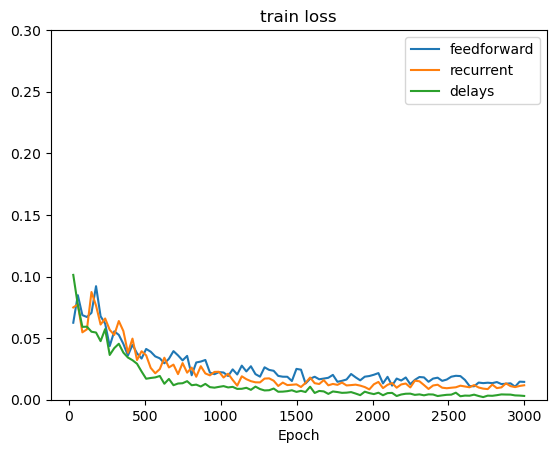

In [5]:
import numpy as np
from snn_delays.utils.visualization_utils import plot_per_epoch
import matplotlib.pyplot as plt
loss_error = np.mean(np.array(snn_f.train_loss)[:,1][-100:])
plot_per_epoch(snn_f.train_loss, label = 'feedforward')
plot_per_epoch(snn_rnn.train_loss, label = 'recurrent')
plot_per_epoch(snn_rd.train_loss, label = 'delays')
#plt.title(f'loss error = {loss_error}')

plt.ylim(0, 0.3)
plt.title('train loss')

In [6]:
snn_f.debug = True
snn_rnn.debug = True
snn_rd.debug = True
snn_f.init_state_logger()
snn_rnn.init_state_logger()
snn_rd.init_state_logger()

from snn_delays.utils.train_utils_refact_minimal import propagate_batch_simple
images, labels_mf = propagate_batch_simple(snn_f, test_loader)
_, labels_rnn = propagate_batch_simple(snn_rnn, test_loader)
_, labels_rd = propagate_batch_simple(snn_rd, test_loader)

In [7]:
ref_mf = labels_mf[:,:int(0.1*time_window), :].permute(1, 0, 2).cpu().numpy()
out_mf = snn_f.mem_state['output'][int(0.9*time_window):].detach().cpu().numpy()

ref_rnn = labels_rnn[:,:int(0.1*time_window), :].permute(1, 0, 2).cpu().numpy()
out_rnn = snn_rnn.mem_state['output'][int(0.9*time_window):].detach().cpu().numpy()

ref_rd = labels_rd[:,:int(0.1*time_window),:].permute(1, 0, 2).cpu().numpy()
out_rd = snn_rd.mem_state['output'][int(0.9*time_window):].detach().cpu().numpy()

from snn_delays.utils.visualization_utils import plot_add_task, plot_add_task2, plot_add_task3, plot_add_task4
# Create a figure with 3 rows and N columns (for stacking results horizontally)

def plot_add_task(output, reference, N, axes=None, name=''):

    ns = 50 # num samples to display for better viz

    ref = reference[:, :ns , N]
    out = output[:, :ns , N]
    diff = abs(ref-out)

    print(np.mean(diff))

    if axes is None:
        fig, axes = plt.subplots(3, 1, figsize=(5, 10))  # Create a new figure if axes not provided

    axes[0].imshow(ref, vmin=0, vmax=0.9)
    axes[0].set_title('Reference '+name)
    axes[0].set_ylabel('Time')

    axes[1].imshow(out, vmin=0, vmax=0.9)
    axes[1].set_title('Output')
    axes[1].set_ylabel('Time')

    axes[2].imshow(diff, vmin=0.0, vmax=0.5)
    axes[2].set_title('Difference')
    axes[2].set_ylabel('Time')
    axes[2].set_xlabel('Training Sample')

    return axes  # Return the axes to be used in an external figure

0.08983846
0.07205154
0.052823864


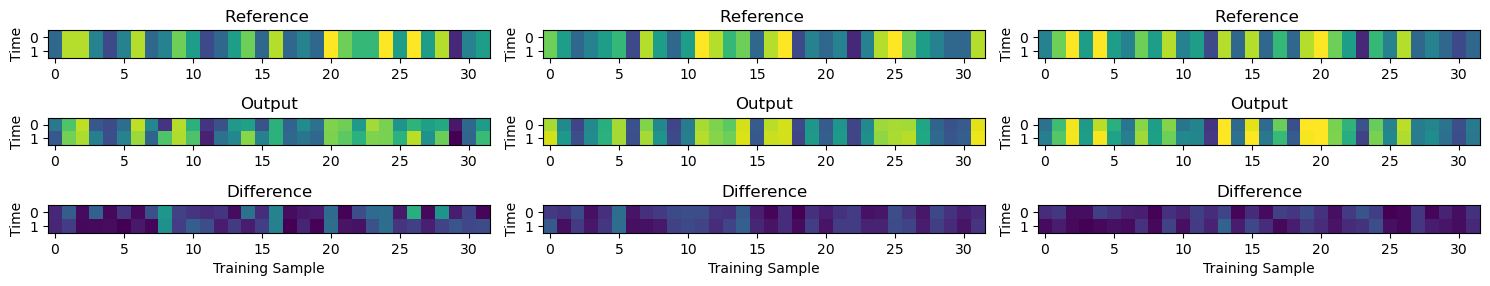

0.092743725
0.09658378
0.048672732


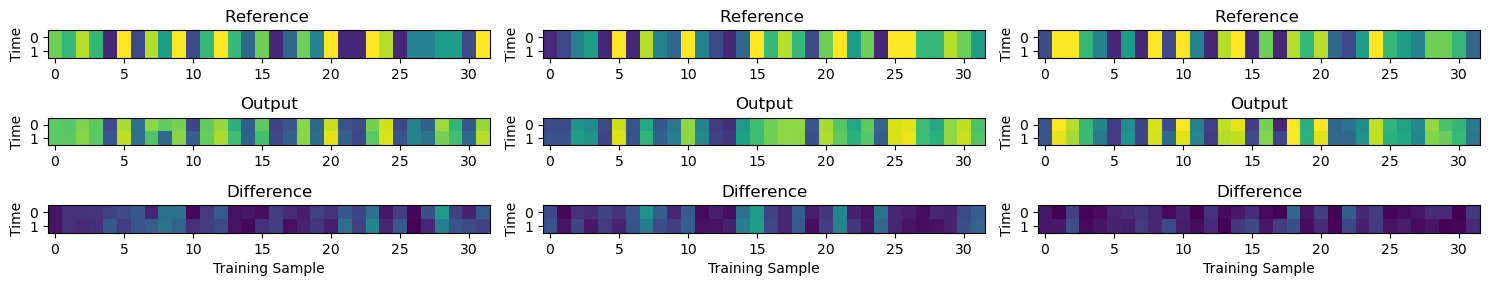

In [8]:
for out_neuron in range(2):

    fig, axes = plt.subplots(3, 3, figsize=(15, 3))  # 3 rows, 2 columns

    plot_add_task(out_mf, ref_mf, out_neuron, axes[:, 0])  
    plot_add_task(out_rnn, ref_rnn, out_neuron, axes[:, 1])  
    plot_add_task(out_rd, ref_rd, out_neuron, axes[:, 2])  

    plt.tight_layout()
    plt.show()